In [1]:
import pickle
import dask.dataframe as ddf
import pandas as pd

In [2]:
years = [2019, 2020, 2021]

In [3]:
education_ps = [
'http://schema.org/courseCode',
'http://schema.org/coursePrerequisite', 
'http://schema.org/courseSku',
'http://schema.org/educationalCredentialAwarded',
'http://schema.org/educationalOutcome',
'http://schema.org/hasCourseInstance', 
'http://schema.org/subjectOfStudy',
"http://schema.org/alignmentType",
"http://schema.org/educationalFramework",
"http://schema.org/educationalAlignment",
"http://schema.org/learningResourceType",
"http://schema.org/interactivityType",
"http://schema.org/educationalUse",
"http://schema.org/educationalLevel",
]

In [18]:
lrmi_predicates = [  
    "http://schema.org/alignmentType",
    "http://schema.org/educationalAlignment",
    "http://schema.org/educationalLevel",
    "http://schema.org/educationalUse",
    "http://schema.org/interactivityType",
    "http://schema.org/isBasedOnUrl",
    "http://schema.org/learningResourceType",
    "http://schema.org/license",
    "http://schema.org/timeRequired",
    "http://schema.org/typicalAgeRange"]

In [ ]:
description_predicates = [
    "http://schema.org/description",
    "http://schema.org/Description",
    "http://purl.org/dc/terms/description"
]

In [59]:
df[description_predicates].sum(axis=1) > 0

subject
hdl:10013/epic.10345.d001          False
hdl:10013/epic.26862.d001          False
hdl:10013/epic.28277.d001          False
hdl:10013/epic.28291.d001          False
hdl:10013/epic.28324.d001          False
                                   ...  
kg:/m/06fbpd                        True
kg:/m/0l8qm8v                       True
kg:/m/0n6gx                         True
urn:nbn:de:gbv:46-diss000101449    False
urn:nbn:de:gbv:46-ep000106655      False
Length: 218816, dtype: bool

In [ ]:
out = []
for year in list(range(2019, 2022)):
    with open(f'../data/lrmiout.predicate_cooccurence_{year}.pkl', 'rb') as f:
        df = pickle.load(f)
    total_subjects = df.shape[0]
    domains = df.index.str.extract('.*:\/\/(.*?)\/.*')[0]
    total_domains = domains.nunique()
    def nsubjects_with_predicates(plist):
        nhas_atleast_one = (df[df.columns.intersection(set(plist))].sum(axis=1) > 0).sum()
        return nhas_atleast_one
    total_w_descriptions = nsubjects_with_predicates(description_predicates)
    total_w_lrmi = nsubjects_with_predicates(lrmi_predicates)
    total_w_lrmi_prime = nsubjects_with_predicates(
        set(lrmi_predicates) - {'http://schema.org/timeRequired', 'http://schema.org/license'})
    total_w_ed = nsubjects_with_predicates(education_ps)
    total_w_lrmi_w_desc = nsubjects_with_predicates(lrmi_predicates + description_predicates)
    total_w_lrmi_prime_w_desc = nsubjects_with_predicates(
        set(lrmi_predicates + description_predicates) - {'http://schema.org/timeRequired', 'http://schema.org/license'})
    total_w_ed_w_dedsc = nsubjects_with_predicates(education_ps + description_predicates)
    out.append(pd.Series({
        'year': year,
        'total_w_descriptions': total_w_descriptions,
        'total_w_lrmi': total_w_lrmi,
        'total_w_lrmi_prime': total_w_lrmi_prime,
        'total_w_ed': total_w_ed,
        'total_w_lrmi_w_desc': total_w_lrmi_w_desc,
        'total_w_lrmi_prime_w_desc': total_w_lrmi_prime_w_desc,
        'total_w_ed_w_dedsc': total_w_ed_w_dedsc
    }))
pd.DataFrame(out)

In [20]:
df.shape

(218816, 298)

In [54]:
(df[description_predicates].sum(axis=1) > 0).sum() / df.shape[0]

0.7972680242761041

In [40]:
import re

def get_domain(url):
    match = re.match('.*:\/\/(.*?)\/.*', url)
    if match:
        return match.groups()[0]
    else:
        return None

In [43]:
education_p_exists_domains = set([get_domain(u) for u in education_p_exists[education_p_exists > 0].index])

In [44]:
lrmi_p_exists_domains = set([get_domain(u) for u in lrmi_p_exists[lrmi_p_exists > 0].index])

In [45]:
len(education_p_exists_domains)

103

In [46]:
len(lrmi_p_exists_domains)

95

In [47]:
len(set(education_p_exists_domains).union(set(lrmi_p_exists_domains)))

132

In [50]:
len(set(education_p_exists_domains).intersection(set(lrmi_p_exists_domains)))

66

In [51]:
len(set(education_p_exists_domains).difference(set(lrmi_p_exists_domains)))

37

In [52]:
len(set(lrmi_p_exists_domains).difference(set(education_p_exists_domains)))

29

In [17]:
import hdbscan
import numpy as np
from tqdm import tqdm

# Load your binary data matrix, assumed to be named 'data'
data = df.values

# Specify the number of clusters you want to generate
n_clusters = 8

# Create a clustering object with the desired parameters
clusterer = hdbscan.HDBSCAN(min_cluster_size=n_clusters, gen_min_span_tree=True)

# Process the data matrix in chunks and fit the clustering algorithm
chunk_size = 10000
for i in tqdm(list(range(0, data.shape[0], chunk_size))):
    chunk_data = data[i:i+chunk_size]
    clusterer.partial_fit(chunk_data)

# Get the predicted cluster labels for the data points
labels = clusterer.labels_

# Print the predicted cluster labels for the first 10 data points
print(labels[:10])


  0%|                                         | 0/22 [00:00<?, ?it/s]


AttributeError: 'HDBSCAN' object has no attribute 'partial_fit'

In [ ]:
kmeans.fit_predict(df)

In [5]:
df.shape

(218816, 298)

In [4]:
for year in years:
    with open(f'../data/p_counts_{year}.pickle', 'rb') as f:
        df = pickle.load(f)
    df.columns = df.columns.droplevel(0)
    col_list = list(df.columns.intersection(set(education_ps)))
    df = df[col_list].dropna(how='all')
    with open(f'../data/p_counts_ed_{year}.pickle', 'wb') as f:
        pickle.dump(df, f)
    

In [46]:
ed_df = dict()
for year in years:
    with open(f'../data/p_counts_ed_{year}.pickle', 'rb') as f:
        df = pickle.load(f)
    ed_df[year] = df

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def pca_plot_clusters(data, n_components=2, n_clusters=2):
    # Standardize the data
    data_std = (data - data.mean()) / data.std()

    # Create a PCA object with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to the data
    pca.fit(data_std)

    # Transform the data using the PCA model
    data_pca = pca.transform(data_std)

    # Cluster the transformed data using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    labels = kmeans.fit_predict(data_pca)

    # Plot the transformed data with colors based on the cluster labels
    fig, ax = plt.subplots()
    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='rainbow')
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("PCA Plot with Clusters")

    # Add a legend
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles, labels, loc="upper right")

    plt.show()


In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

def pca_plot_clusters_dbscan(data, n_components=2, eps=0.5, min_samples=5):
    # Standardize the data
    data_std = (data - data.mean()) / data.std()

    # Create a PCA object with the desired number of components
    pca = PCA(n_components=n_components)

    # Fit the PCA model to the data
    pca.fit(data_std)

    # Transform the data using the PCA model
    data_pca = pca.transform(data_std)

    # Cluster the transformed data using DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data_pca)

    # Plot the transformed data with colors based on the cluster labels
    fig, ax = plt.subplots()
    scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='rainbow')
    ax.set_xlabel("PC1")
    ax.set


/home/rsebastian/.anaconda3/envs/lwva/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


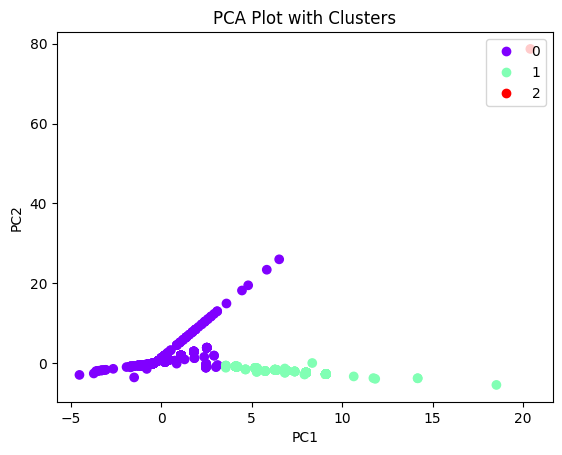

In [15]:
pca_plot_clusters(ed_df[2019].fillna(0), n_clusters=3)

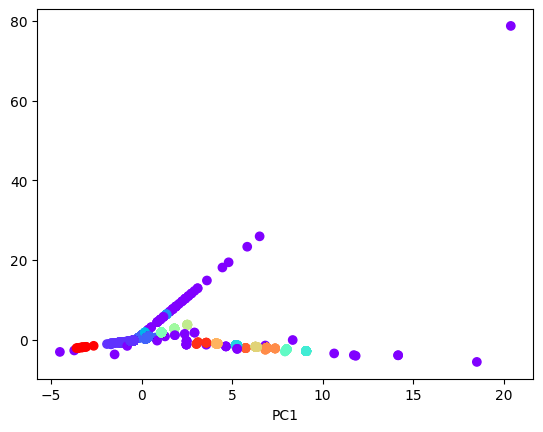

In [17]:
pca_plot_clusters_dbscan(ed_df[2019].fillna(0), eps=0.5)

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_multivariate_data(X, y):
    """
    Plot multivariate data on a 2D scatter plot using PCA.
    
    Parameters:
    X (numpy.ndarray): A matrix of shape (n_samples, n_features) containing the multivariate data.
    y (numpy.ndarray): A vector of shape (n_samples,) containing the labels for each sample.
    
    Returns:
    None
    
    """
    # Initialize PCA object
    pca = PCA(n_components=2)

    # Fit the data to PCA
    pca.fit(X)

    # Project the data onto the first two principal components
    X_pca = pca.transform(X)

    # Get unique labels
    labels = np.unique(y)

    # Plot the data for each label
    for label in labels:
        plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=label)

    # Set plot title and axis labels
    plt.title('Multivariate Data Plot using PCA')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    # Show legend and plot
    plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.show()


In [22]:
import pandas as pd

def threshold_categorical(series, threshold):
    """
    Given a pandas series, returns a pandas series of the same size such that items in the series
    that are more frequent than a certain threshold are left as is and everything else is changed
    to the string "other".
    
    Parameters:
    series (pandas.Series): The input series.
    threshold (int): The frequency threshold below which items are replaced with "other".
    
    Returns:
    pandas.Series: A new pandas series with the same size as the input series.
    
    """
    # Compute the frequency of each value in the series
    value_counts = series.value_counts()

    # Compute the mask of values that occur more frequently than the threshold
    mask = value_counts >= threshold

    # Initialize the output series with "other" for all values
    output_series = pd.Series("other", index=series.index)

    # For values that occur more frequently than the threshold, copy them to the output series
    for value, count in value_counts[mask].iteritems():
        output_series[series == value] = value

    return output_series


In [69]:
import pandas as pd

def filter_by_quantile(df, column, quantile):
    """
    Given a pandas dataframe, filters it based on the frequency of a given column.
    
    Parameters:
    df (pandas.DataFrame): The input dataframe.
    column (str): The name of the column to filter on.
    threshold (int): The frequency threshold below which rows are removed.
    
    Returns:
    pandas.DataFrame: A new pandas dataframe containing only the rows with values in the specified column
    that occur more frequently than the threshold.
    
    """
    # Compute the frequency of each value in the specified column
    value_counts = df[column].value_counts()

    # Compute the mask of values that occur more frequently than the threshold
    threshold = value_counts.quantile(quantile)

    # Compute the mask of values that occur more frequently than the threshold
    mask = value_counts >= threshold
    # Get the values to keep
    values_to_keep = value_counts[mask].index.tolist()

    # Filter the dataframe based on the specified column
    filtered_df = df[df[column].isin(values_to_keep)]

    return filtered_df


In [88]:
year = 2019
ed_df[year]['pld'] = ed_df[year].index.str.extract('^.*:\/\/(.*?)\/.*$')[0].values

filtered_df = filter_by_quantile(ed_df[year], 'pld', 0.2)
# plot_multivariate_data(filtered_df.drop(columns=['pld']).fillna(0), filtered_df.pld)

In [89]:
for i in filtered_df.pld.unique():
    cols = ed_df[year][ed_df[year].pld == i].dropna(axis=1, how='all').columns.values
    cols = [c.split('/')[-1] for c in cols if c!='pld']
    print(i, cols)

allmetalsrl.com ['educationalUse', 'interactivityType']
codegalaxy.io ['learningResourceType']
commons.esipfed.org ['educationalUse', 'interactivityType', 'learningResourceType']
explainme.co ['learningResourceType']
kapush.org ['educationalUse', 'learningResourceType']
knoesis.org ['learningResourceType']
knoesis.wright.edu ['learningResourceType']
primeexpert24.com ['educationalUse', 'interactivityType']
uk.codegalaxy.io ['learningResourceType']
unrwa-stg.dev-site.online ['learningResourceType']
www.knoesis.org ['learningResourceType']
aldolafontana.be ['interactivityType']
aporiasas.fr ['interactivityType']
association-maison-familiale.com ['interactivityType']
atmosfaire.fr ['interactivityType']
az-box.fr ['interactivityType']
cloudxlab.com ['courseCode', 'hasCourseInstance']
dis-confort.fr ['interactivityType']
ekloges-apotelesmata.eu ['interactivityType']
eleicoes-resultados.eu ['interactivityType']
fac-logistique.com ['interactivityType']
face-on-putting.com ['interactivityType'

In [65]:
ed_df[year]['pld']

s
http://allmetalsrl.com/apartado/celeridad                                                                                                                              allmetalsrl.com
http://codegalaxy.io/courses/cplusplus/questions/00e8d7693fc248eb93bd1643ea7d36cf/select-all-the-correct-ways-to-declare-the-local-constant-in-the-code-block            codegalaxy.io
http://codegalaxy.io/courses/cplusplus/questions/018efba65ef64f47ba456b5c50ba34b0/kakoj-iz-perechislennyh-tipov-dannyh-ne-yavlyaetsya-fundamental-nym                    codegalaxy.io
http://codegalaxy.io/courses/cplusplus/questions/019aeb8566bd4bd59da9384767b93272/will-the-following-code-compile-class-clazz                                            codegalaxy.io
http://codegalaxy.io/courses/cplusplus/questions/01d7536a360e4cb9935294cc2119b832/chto-vyvedet-sleduyushchij-kod-include-lt-iostream-gt-void-print-int-a-std-cout-       codegalaxy.io
                                                                                   